<h1 style='color: Orange' align='center'>Sports Celebrity Image Classification<h1>

In [1]:
import numpy as np
import cv2, pywt, os, joblib, json
import matplotlib.pyplot as plt
import pandas as pd

<h3 style='color:purple'>(1) Preprocessing: Detect face and eyes</h3>

Creating an algorithm for preprocessing the images which removes the pictures in which atleast two eyes are detected which would mean that face is clearly visible. I am going to make use of HaarCascade classifier.

In [2]:
img = cv2.imread('./dataset/Images/virat kohli/kohli1.jpg')
img.shape

(480, 640, 3)

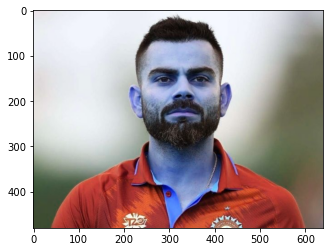

In [3]:
plt.imshow(img)

### Converting 3 color channel image to 1 color channel to reduce dimensions of image.

In [4]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray

array([[230, 230, 230, ..., 197, 197, 197],
       [230, 230, 230, ..., 197, 197, 197],
       [230, 230, 230, ..., 196, 196, 196],
       ...,
       [ 66,  66,  66, ..., 113, 114, 115],
       [ 66,  66,  66, ..., 113, 113, 114],
       [ 66,  66,  66, ..., 112, 113, 114]], dtype=uint8)

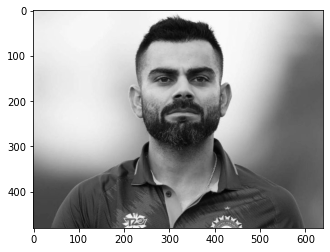

In [5]:
plt.imshow(gray, cmap='gray');

In [6]:
face_cascade = cv2.CascadeClassifier('./Haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./Haarcascades/haarcascade_eye.xml')

face = face_cascade.detectMultiScale(gray,1.3,5)       
eyes = eye_cascade.detectMultiScale(gray,1.1,3)        
face, eyes

(array([[218,  60, 221, 221]]),
 array([[285, 391,  28,  28],
        [340, 124,  52,  52],
        [261, 127,  50,  50]]))

Suppose, the scale factor is 1.03, it means we're using a small step for resizing, i.e. reduce size by 3 %, we increase the chance of a matching size with the model for detection is found, while it's expensive.
minNeighbors : Parameter specifying how many neighbors each candidate rectangle should have to retain it. This parameter will affect the quality of the detected faces: higher value results in less detections but with higher quality. We're using 5 in the code.
flags : Parameter with the same meaning for an old cascade as in the function cvHaarDetectObjects. It is not used for a new cascade.
minSize : Minimum possible object size. Objects smaller than that are ignored.
maxSize : Maximum possible object size. Objects larger than that are ignored.

In [7]:
eyes[0]

array([285, 391,  28,  28])

In [8]:
(x,y,w,h) = face[0]
e1,e2,e3,e4 = eyes[0]
e5,e6,e7,e8 = eyes[1]

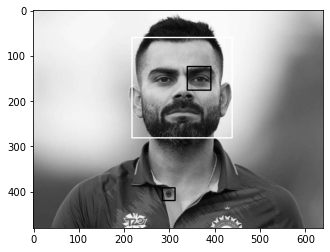

In [9]:
cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),(2))
cv2.rectangle(gray,(e1,e2),(e1+e3,e2+e4),(0,255,0),(2))
cv2.rectangle(gray,(e5,e6),(e5+e7,e6+e8),(0,255,0),(2))
plt.imshow(gray, cmap='gray')

## 2. View cropped face

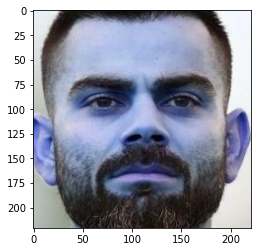

In [10]:
cropped_img = img[y:y+h,x:x+w]
plt.imshow(cropped_img, cmap='gray')

### Using wavelet transform as feature.
Images have smooth region interrupted by edges or abrupt change in contrast. These abrupt changes provide a lot of information.
A wavelet is a rapidly decaying wave like oscillation that has zero mean existing for a finite duration unlike sinosuidal waves.

In [11]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

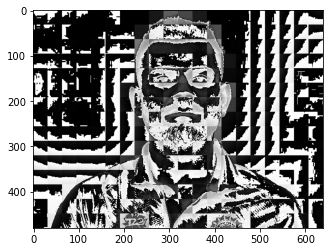

In [12]:
im_har = w2d(img,'db1',5)
plt.imshow(im_har, cmap='gray')

You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

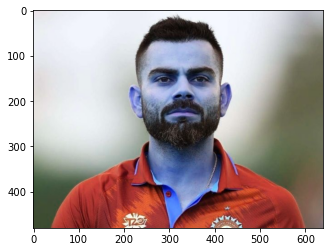

In [13]:
plt.imshow(img)

<h3 style='color:purple'>(3) Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region</h3>

In [14]:
def img_processing(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = img[y:y+h,x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

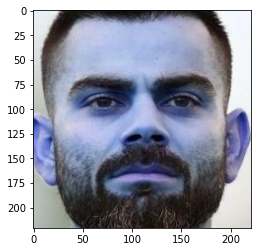

In [15]:
plt.imshow(img_processing('./dataset/Images/virat kohli/kohli1.jpg'));

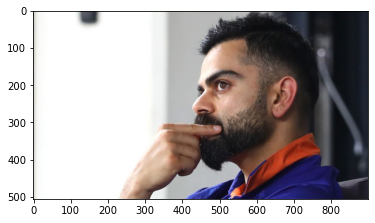

In [16]:
plt.imshow(plt.imread('./dataset/Images/virat kohli/kohli2.jpg'));

In [17]:
img_processing('./dataset/Images/virat kohli/kohli2.jpg')                # nothing is returned as both eyes are not visible.

In [18]:
path_to_data = './dataset/Images'
path_to_cr = './dataset/CroppedImages'

In [19]:
img_dirs = []

for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
        
img_dirs

['./dataset/Images\\abdul kalam',
 './dataset/Images\\harnaaz sandhu',
 './dataset/Images\\neeraj chopra',
 './dataset/Images\\sunil chhetri',
 './dataset/Images\\virat kohli']

In [20]:
import shutil
if os.path.exists(path_to_cr):
     shutil.rmtree(path_to_cr)                 #rmtree = remove all folders and files
os.mkdir(path_to_cr)

In [21]:
cropped_img_dirs = []

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('\\')[-1]
    for entry in os.scandir(img_dir):
        roi_color = img_processing(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr+'/'+celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_img_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + '.jpg'
            cropped_file_path = cropped_folder +'/' + cropped_file_name
            cv2.imwrite(cropped_file_path,roi_color)
            count += 1

Generating cropped images in folder:  ./dataset/CroppedImages/abdul kalam
Generating cropped images in folder:  ./dataset/CroppedImages/harnaaz sandhu
Generating cropped images in folder:  ./dataset/CroppedImages/neeraj chopra
Generating cropped images in folder:  ./dataset/CroppedImages/sunil chhetri
Generating cropped images in folder:  ./dataset/CroppedImages/virat kohli


Cropped images have been saved in their respective folder. Now I need to manually examine the processed dataset.

In [41]:
celebs_file_names_dict = {}
for name in cropped_img_dirs:
    celeb = name.split('/')[-1]
    file_list = []
    for files in os.scandir(name):
        file_list.append(files.path)
        celebs_file_names_dict[celeb] = file_list
celebs_file_names_dict

{'abdul kalam': ['./dataset/CroppedImages/abdul kalam\\abdul kalam1.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam11.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam12.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam13.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam14.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam15.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam16.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam17.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam19.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam2.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam20.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam3.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam5.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam6.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam7.jpg',
  './dataset/CroppedImages/abdul kalam\\abdul kalam8.jpg',
  './dataset/CroppedImages/abdul

### The above dictionary conatins list of files remaining after manual inspection of the cropped images folder.

In [23]:
class_dict = {}
count = 0
for celebrity_name in celebs_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'abdul kalam': 0,
 'harnaaz sandhu': 1,
 'neeraj chopra': 2,
 'sunil chhetri': 3,
 'virat kohli': 4}

## 4. Preprocessing

In [43]:
X,y = [],[]

for celeb_name,training_files in celebs_file_names_dict.items():
    for training_file in training_files:
        img = cv2.imread(training_file)
        scaled_raw_img = cv2.resize(img,(32,32))
        wav = w2d(img,'db1',5)
        scaled_wyt = cv2.resize(wav, (32, 32))
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_wyt.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celeb_name])

In [44]:
X[0].shape

(4096, 1)

In [45]:
32*32*3 + 32*32

4096

In [46]:
y[0]

0

In [47]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(137, 4096)

### Data cleaning process is done. Now we are ready to train our model.
### Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [48]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [50]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [0,1,10],
            'svc__kernel': ['rbf','linear','polynomial']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [10,50,90,160]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [51]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\DELL\anaconda33\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\DELL\anaconda33\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DELL\anaconda33\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\DELL\anaconda33\lib\site-packages\sklearn\svm\_base.py", line 226, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\DELL\anaconda33\lib\site-packages\sklearn\svm\_base.py", line 277, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 192, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  warnings.warn("Estimator fit 

C:\Users\DELL\anaconda33\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\DELL\anaconda33\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DELL\anaconda33\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\DELL\anaconda33\lib\site-packages\sklearn\svm\_base.py", line 226, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\DELL\anaconda33\lib\site-packages\sklearn\svm\_base.py", line 277, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 176, in sklearn.svm._libsvm.fit
ValueError: 'polynomial' is not in list

  warnings

C:\Users\DELL\anaconda33\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\DELL\anaconda33\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DELL\anaconda33\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\DELL\anaconda33\lib\site-packages\sklearn\svm\_base.py", line 226, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\DELL\anaconda33\lib\site-packages\sklearn\svm\_base.py", line 277, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 176, in sklearn.svm._libsvm.fit
ValueError: 'polynomial' is not in list

  warnings

,model,best_score,best_params
0,svm,0.880952,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.843333,{'randomforestclassifier__n_estimators': 90}
2,logistic_regression,0.872857,{'logisticregression__C': 1}


In [52]:
best_estimators['svm'].score(X_test,y_test)

0.8

In [53]:
best_estimators['random_forest'].score(X_test,y_test)

0.7714285714285715

In [54]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8857142857142857

Text(69.0, 0.5, 'Truth')

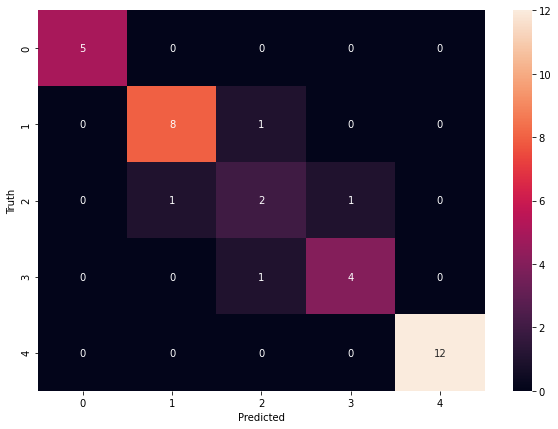

In [55]:
from sklearn.metrics import confusion_matrix

best_clf = best_estimators['logistic_regression']
cm = confusion_matrix(y_test, best_clf.predict(X_test))
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [56]:
class_dict

{'abdul kalam': 0,
 'harnaaz sandhu': 1,
 'neeraj chopra': 2,
 'sunil chhetri': 3,
 'virat kohli': 4}

### Save the trained model

In [57]:
joblib.dump(best_clf,'saved_model.pkl')

['saved_model.pkl']

In [58]:
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))